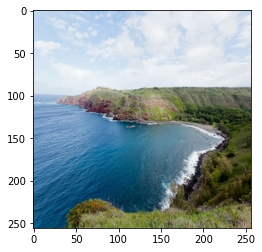

In [4]:
# Make sure the images are there
import cv2
import matplotlib.pyplot as plt
img_fol_path ="./images/val/class/08eff84bc2b09085e6134e1e6a29c50c.jpg"
img = cv2.imread(img_fol_path)
img1  = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [30]:
import numpy as np
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
import os, shutil, time
%matplotlib inline

In [33]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128
        resnet = models.resnet18(num_classes=365) 
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

        self.upsample = nn.Sequential(     
          nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
          nn.Upsample(scale_factor=2)
        )

    def forward(self, input):

        midlevel_features = self.midlevel_resnet(input)

        output = self.upsample(midlevel_features)
        return output

In [34]:
model = ColorizationNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [37]:
class GrayscaleImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            img_lab = rgb2lab(img_original)
            img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            img_original = rgb2gray(img_original)
            img_original = torch.from_numpy(img_original).unsqueeze(0).float()
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img_original, img_ab, target

In [38]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])

val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [39]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial''' 
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):

    plt.clf()
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy()
    color_image = color_image.transpose((1, 2, 0)) 
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

#### Validation

In validation, we simply run model without backpropagation using `torch.no_grad`. 

In [40]:
def validate(val_loader, model, criterion, save_images, epoch):
    model.eval()

    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab, target) in enumerate(val_loader):
        data_time.update(time.time() - end)

    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    output_ab = model(input_gray)
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    if save_images and not already_saved_images:
        already_saved_images = True
        for j in range(min(len(output_ab), 10)):
            save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
            save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
            to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    batch_time.update(time.time() - end)
    end = time.time()

    if i % 25 == 0:
        print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
            i, len(val_loader), batch_time=batch_time, loss=losses))

    print('Finished validation.')
    return losses.avg

In [41]:
def train(train_loader, model, criterion, optimizer, epoch):
    print('Starting training epoch {}'.format(epoch))
    model.train()
  
    # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    for i, (input_gray, input_ab, target) in enumerate(train_loader):
        if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()
        
        data_time.update(time.time() - end)

        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        losses.update(loss.item(), input_gray.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % 25 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                  epoch, i, len(train_loader), batch_time=batch_time,
                 data_time=data_time, loss=losses)) 

    print('Finished training epoch {}'.format(epoch))

In [45]:
if use_gpu: 
    criterion = criterion.cuda()
    model = model.cuda()
    
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 100

for epoch in range(epochs):
    train(train_loader, model, criterion, optimizer, epoch)
    with torch.no_grad():
        losses = validate(val_loader, model, criterion, save_images, epoch)
    if losses < best_losses:
        best_losses = losses
        torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Finished validation.


<Figure size 432x288 with 0 Axes>

In [44]:
# Validate
save_images = True
with torch.no_grad():
    validate(val_loader, model, criterion, save_images, 0)

Starting training epoch 0


C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Epoch: [0][0/16]	Time 3.731 (3.731)	Data 2.440 (2.440)	Loss 0.4092 (0.4092)	
Finished training epoch 0


C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 32546 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 46684 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 23858 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 37906 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\c

Finished validation.
Starting training epoch 1
Epoch: [1][0/16]	Time 4.178 (4.178)	Data 2.926 (2.926)	Loss 0.0128 (0.0128)	
Finished training epoch 1


C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 32 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 3 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 8 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 50 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv

Finished validation.
Starting training epoch 2
Epoch: [2][0/16]	Time 4.078 (4.078)	Data 2.818 (2.818)	Loss 0.0061 (0.0061)	
Finished training epoch 2
Finished validation.
Starting training epoch 3
Epoch: [3][0/16]	Time 4.206 (4.206)	Data 2.962 (2.962)	Loss 0.0036 (0.0036)	
Finished training epoch 3
Finished validation.
Starting training epoch 4
Epoch: [4][0/16]	Time 4.235 (4.235)	Data 2.975 (2.975)	Loss 0.0049 (0.0049)	
Finished training epoch 4


C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished validation.
Starting training epoch 5
Epoch: [5][0/16]	Time 4.138 (4.138)	Data 2.879 (2.879)	Loss 0.0043 (0.0043)	
Finished training epoch 5
Finished validation.
Starting training epoch 6
Epoch: [6][0/16]	Time 4.367 (4.367)	Data 3.113 (3.113)	Loss 0.0055 (0.0055)	
Finished training epoch 6
Finished validation.
Starting training epoch 7
Epoch: [7][0/16]	Time 4.150 (4.150)	Data 2.904 (2.904)	Loss 0.0036 (0.0036)	
Finished training epoch 7


C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 7 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished validation.
Starting training epoch 8
Epoch: [8][0/16]	Time 4.030 (4.030)	Data 2.782 (2.782)	Loss 0.0032 (0.0032)	
Finished training epoch 8
Finished validation.
Starting training epoch 9
Epoch: [9][0/16]	Time 3.947 (3.947)	Data 2.702 (2.702)	Loss 0.0023 (0.0023)	
Finished training epoch 9
Finished validation.
Starting training epoch 10
Epoch: [10][0/16]	Time 4.068 (4.068)	Data 2.822 (2.822)	Loss 0.0048 (0.0048)	
Finished training epoch 10


C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 9 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished validation.
Starting training epoch 11
Epoch: [11][0/16]	Time 3.989 (3.989)	Data 2.742 (2.742)	Loss 0.0030 (0.0030)	
Finished training epoch 11
Finished validation.
Starting training epoch 12
Epoch: [12][0/16]	Time 4.039 (4.039)	Data 2.795 (2.795)	Loss 0.0047 (0.0047)	
Finished training epoch 12
Finished validation.
Starting training epoch 13
Epoch: [13][0/16]	Time 4.857 (4.857)	Data 3.603 (3.603)	Loss 0.0031 (0.0031)	
Finished training epoch 13
Finished validation.
Starting training epoch 14
Epoch: [14][0/16]	Time 4.766 (4.766)	Data 3.508 (3.508)	Loss 0.0029 (0.0029)	
Finished training epoch 14
Finished validation.
Starting training epoch 15
Epoch: [15][0/16]	Time 3.936 (3.936)	Data 2.683 (2.683)	Loss 0.0035 (0.0035)	
Finished training epoch 15
Finished validation.
Starting training epoch 16
Epoch: [16][0/16]	Time 4.107 (4.107)	Data 2.863 (2.863)	Loss 0.0039 (0.0039)	
Finished training epoch 16
Finished validation.
Starting training epoch 17
Epoch: [17][0/16]	Time 4.051 (4.05

C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished validation.
Starting training epoch 18
Epoch: [18][0/16]	Time 3.970 (3.970)	Data 2.725 (2.725)	Loss 0.0034 (0.0034)	
Finished training epoch 18
Finished validation.
Starting training epoch 19
Epoch: [19][0/16]	Time 3.874 (3.874)	Data 2.623 (2.623)	Loss 0.0031 (0.0031)	
Finished training epoch 19
Finished validation.
Starting training epoch 20
Epoch: [20][0/16]	Time 3.925 (3.925)	Data 2.680 (2.680)	Loss 0.0037 (0.0037)	
Finished training epoch 20
Finished validation.
Starting training epoch 21
Epoch: [21][0/16]	Time 3.870 (3.870)	Data 2.619 (2.619)	Loss 0.0031 (0.0031)	
Finished training epoch 21
Finished validation.
Starting training epoch 22
Epoch: [22][0/16]	Time 4.208 (4.208)	Data 2.961 (2.961)	Loss 0.0031 (0.0031)	
Finished training epoch 22
Finished validation.
Starting training epoch 23
Epoch: [23][0/16]	Time 3.921 (3.921)	Data 2.676 (2.676)	Loss 0.0031 (0.0031)	
Finished training epoch 23
Finished validation.
Starting training epoch 24
Epoch: [24][0/16]	Time 4.072 (4.07

Finished training epoch 71
Finished validation.
Starting training epoch 72
Epoch: [72][0/16]	Time 4.506 (4.506)	Data 3.263 (3.263)	Loss 0.0026 (0.0026)	
Finished training epoch 72
Finished validation.
Starting training epoch 73
Epoch: [73][0/16]	Time 4.707 (4.707)	Data 3.463 (3.463)	Loss 0.0029 (0.0029)	
Finished training epoch 73
Finished validation.
Starting training epoch 74
Epoch: [74][0/16]	Time 4.350 (4.350)	Data 3.101 (3.101)	Loss 0.0029 (0.0029)	
Finished training epoch 74
Finished validation.
Starting training epoch 75
Epoch: [75][0/16]	Time 4.181 (4.181)	Data 2.928 (2.928)	Loss 0.0024 (0.0024)	
Finished training epoch 75
Finished validation.
Starting training epoch 76
Epoch: [76][0/16]	Time 4.541 (4.541)	Data 3.298 (3.298)	Loss 0.0028 (0.0028)	
Finished training epoch 76
Finished validation.
Starting training epoch 77
Epoch: [77][0/16]	Time 4.694 (4.694)	Data 3.450 (3.450)	Loss 0.0029 (0.0029)	
Finished training epoch 77
Finished validation.
Starting training epoch 78
Epoch: 

<Figure size 432x288 with 0 Axes>

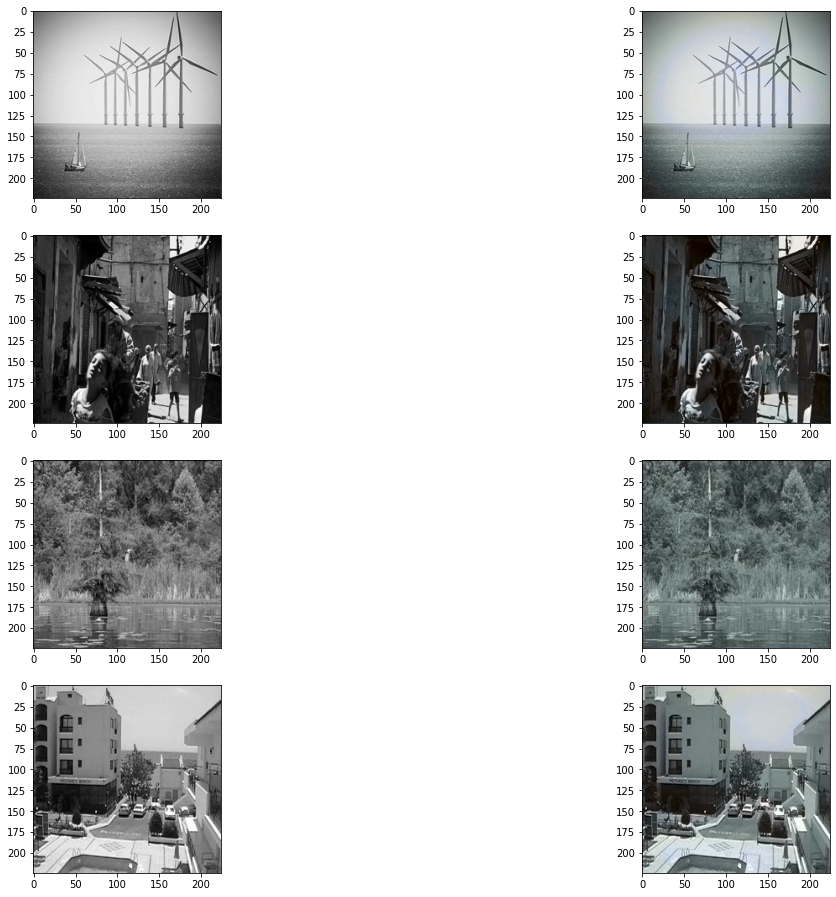

In [28]:
img_list = ['outputs/color/img-448-epoch-0.jpg', 'outputs/gray/img-448-epoch-0.jpg',
            'outputs/color/img-450-epoch-1.jpg', 'outputs/gray/img-450-epoch-1.jpg',
           'outputs/color/img-265-epoch-93.jpg', 'outputs/gray/img-265-epoch-93.jpg',
            'outputs/color/img-264-epoch-90.jpg', 'outputs/gray/img-264-epoch-90.jpg']
cv_imRead = []
for im in img_list:
    a = cv2.imread(im)
    cv_imRead.append(a)


def display_images(images, rows, cols, size):
    fig = plt.figure(figsize = size)
    c = 0
    sz = len(images)
    for i in range(rows):
        for j in range(cols):
            if sz == c:
                break
            ax1 = fig.add_subplot(rows, cols, c + 1)
            ax1.imshow(images[c], cmap = 'gray')
            c = c + 1
    plt.show()
    
display_images(cv_imRead , 5, 2, (20, 20))
